In [1]:
from torch.utils.data import DataLoader
from DDPM_for_Audio.diffuse import forwardDiff
from DDPM_for_Audio.data import PianoSet, collate_fn

In [2]:
dataset = PianoSet(path_to_data="/Users/roywang/Schools/Project/archive")
data = DataLoader(dataset, batch_size=None, batch_sampler=None, shuffle=True, collate_fn=collate_fn)
for audio in data:
    print(audio.shape)

torch.Size([4, 1, 176400])
torch.Size([4, 1, 44100])
torch.Size([4, 1, 44100])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 44100])
torch.Size([4, 1, 88200])
torch.Size([4, 1, 44100])
torch.Size([4, 1, 220500])
torch.Size([4, 1, 176400])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 88200])
torch.Size([4, 1, 44100])
torch.Size([4, 1, 220500])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 220500])
torch.Size([4, 1, 176400])
torch.Size([4, 1, 44100])
torch.Size([4, 1, 88200])
torch.Size([4, 1, 176400])
torch.Size([4, 1, 220500])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 88200])
torch.Size([4, 1, 176400])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 176400])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 220500])
torch.Size([4, 1, 220500])
torch.Size([4, 1, 132300])
torch.Size([4, 1, 176400])


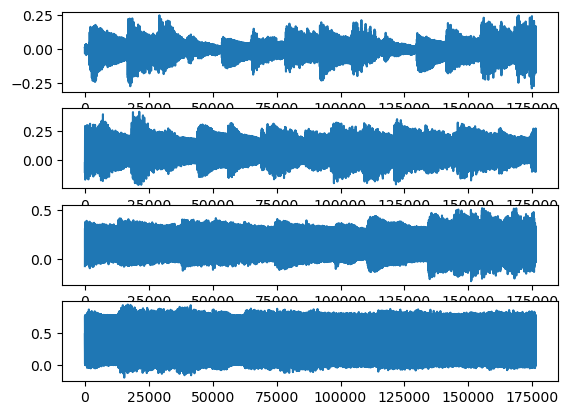

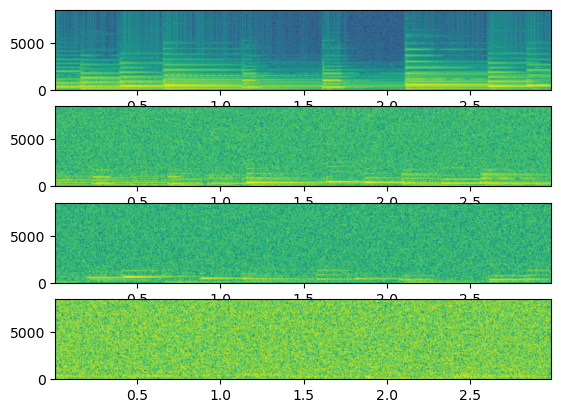

In [4]:
import DDPM_for_Audio.utils as util
dif = forwardDiff(1e-7, 0.01)
tm_stp = [0, 50, 100, 300]
util.visualize_noising(next(iter(data)), tm_stp, dif)
util.visualize_noising_as_mel(next(iter(data)), tm_stp, dif)